## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [1]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM

from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os


device = torch.device('cpu')

Ici on importe le dataset FashionMNIST normalisation et random split pour l'entrainement

In [2]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [8]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 10 EPOCH

In [4]:
model =AbstractNN(num_depth=1,device=torch.device('cpu'))

num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

----------------------------------------------------------------------------------------------------
Epoch 0/10
----------------------------------------------------------------------------------------------------


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 51.76 %
****************************************************************************************************
train Loss: 1.7699 Acc: 51.7578
****************************************************************************************************
EPOCH ACCURACY = 75.22 %
****************************************************************************************************
val Loss: 1.7465 Acc: 75.2184
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Epoch 1/10
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 78.52 %
****************************************************************************************************
train Loss: 1.6856 Acc: 78.5156
****************************************************************************************************
EPOCH ACCUR

In [10]:
model=AbstractNN(num_depth=1,device=torch.device('cpu')    )
model.load_state_dict(torch.load('dataset/FMNIST.pth'))
device = torch.device('cpu')
model.to(device)

AbstractNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=64, bias=True)
  )
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
  (softMax): Softmax(dim=None)
)

Label:9


torch.Size([1, 28, 28])

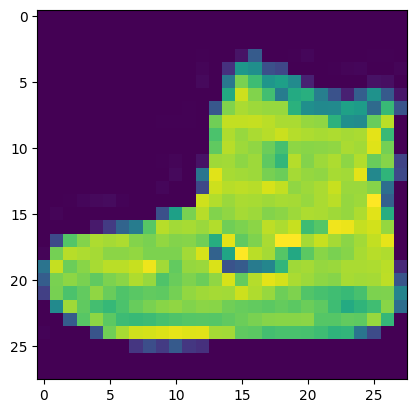

In [11]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[0]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [12]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.001*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)


tensor(5.)
torch.Size([786, 1, 28, 28])


In [13]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([883, 16, 26, 26])
x.shape=torch.Size([1324, 32, 24, 24])
x.shape=torch.Size([1324, 32, 24, 24])
x.shape=torch.Size([1324, 32, 24, 24])
x.shape=torch.Size([1324, 32, 24, 24])
y_min       =  tensor([-0.0000, -0.0000, -0.0000, -0.0000, 10.1103, -0.4929, -0.0000,  4.5107,
         1.0596, 38.4722])
y_max       =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000, 11.9574,  1.0458,  0.0000,  6.3615,
         2.7227, 39.9064])
center Ztp  =  tensor([-0.0000, -0.0000, -0.0000, -0.0000, 11.0338,  0.2765, -0.0000,  5.4361,
         1.8911, 39.1893])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, 11.0493,  0.1279,  0.0000,  5.4165,
          1.8407, 39.1690]])
y_max-x_min =  tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.8471, 1.5387, 0.0000, 1.8508, 1.6631,
        1.4341])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


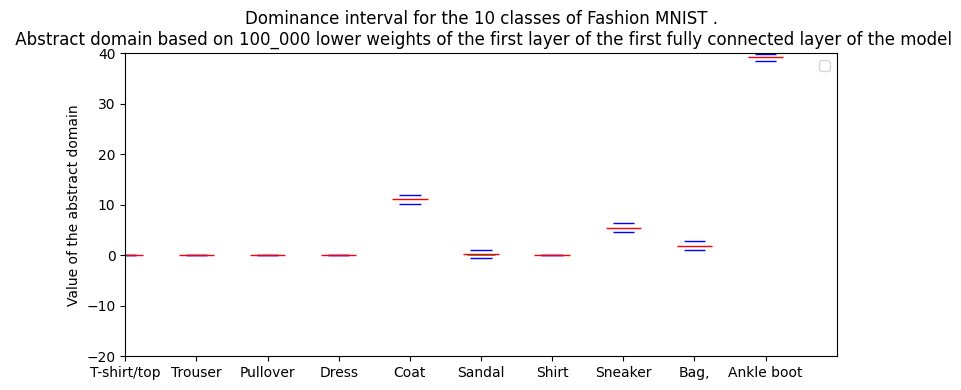

In [14]:

y_min       =  np.array(x_min)
y_max       =  np.array(x_max)
center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)
y_max_minus_y_min =  np.array(x_max-x_min)
Trash_symbol=  np.array(result[-1])


import matplotlib.pyplot as plt
import numpy as np




x = np.arange(len(y_min))
D =np.stack((y_min,y_max),axis=1)

print(D.shape)
print(center_Ztp.shape)
print(y_true.shape)
# plot:

fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

ax.set(xlim=(0, 10),xticks=x,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
       ylim=(-20, 40))
plt.ylabel("Value of the abstract domain")
plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
plt.legend()
plt.show()

Voici le premier affichage de relevance calculé par AbstractTorch

tensor(9)
torch.Size([784])


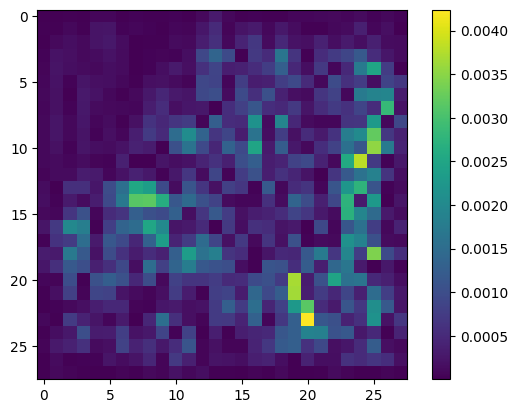

In [15]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:785,value])
print(concat.size())

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()